In [15]:
#Import required modules
import numpy as np
from scipy.interpolate import interp1d
import h5py
import matplotlib.pyplot as plt
from gwosc.datasets import event_gps
%matplotlib notebook

First import data from around GW150914 and whiten

In [72]:
def Hann(n, N):
    """Evalute a Hann window of length N at n"""
    y = 0.5*(1-np.cos(2*np.pi*n/(N-1)))
    return y


def calcpsd(x, y, windowl, window):
    """Calculate the PSD from the signal time series averaged from the PSDs of length windowl.
    Use given window to smooth each fft. Return the PSD as an interpolated function"""
    dx = x[1] - x[0]
    neach = int(windowl/dx)
    nfft = int(2 * len(y)//neach - 1)
    shift = int(np.ceil(neach/2))
    freq = np.fft.rfftfreq(neach, dx)
    asds = np.zeros((nfft, len(freq)), dtype='complex')
    psds = np.zeros((nfft, len(freq)), dtype='complex')
    mask = window(np.arange(neach), neach)
    for i in range(0, nfft):
        windowed = y[i*shift:i*shift + neach]*mask
        asds[i, :] = np.fft.rfft(windowed)
        psds[i, :] = asds[i, :]*np.conj(asds[i, :])
    psd = np.mean(psds**(0.5), axis=0)**2
    psdi = interp1d(freq, np.real(psd), axis=0, bounds_error=False, fill_value=0)
    return psdi


def whiten(x, y, psd0, trunct):
    """use interpolated psd to whiten given data"""
    dx = x[1] - x[0]
    num = np.size(x)
    fs = int(1/dx)
    freqs = np.fft.rfftfreq(num, dx)
    """
    fullf_psd = psd0(freqs)
    fullt_psd = np.fft.irfft(fullf_psd)
    cutstart = int(len(fullt_psd)//2) - int(trunct*fs/2)
    trunct_psd = fullt_psd[cutstart:cutstart+trunct*fs]
    truncf_psd_f = np.fft.rfftfreq(len(trunct_psd), dx)
    truncf_psd_a = np.fft.rfft(trunct_psd)
    psd = interp1d(truncf_psd_f, (truncf_psd_a*np.conj(truncf_psd_a))**0.5, axis=0, bounds_error=False, fill_value=0)
    """
    yft = np.fft.rfft(y)
    white_yft = yft/(np.sqrt(psd0(freqs)))
    white_y = np.fft.irfft(white_yft, n=num)
    return np.real(white_y)


#Read a peice of strain data
filename = '../Data/H-H1_LOSC_4_V2-1126257414-4096.hdf5'
f = h5py.File(filename, 'r')
strain0 = f['strain/Strain'][()]
dt = f['strain/Strain'].attrs['Xspacing']
tstart = f['meta/GPSstart'][()]
tend = f['meta/Duration'][()] + tstart
f.close()

#Create a time vector starting at 0, and get the sampling frequency
ts0 = np.arange(0, tend-tstart, dt)
fs = int(1/dt)
print('time = ', (tend - tstart), ' namples = ', len(strain0), ' sample rate = ', fs)
eventt = event_gps('GW150914') - tstart
print('GW150914 merger occured at t = ', eventt)

#Whiten the strain data
psd = calcpsd(ts0, strain0, 4, Hann)
strain1 = whiten(ts0, strain0, psd, 4)

#Cut time-series to small section around event
strain = strain1[int((eventt-10)*fs):int((eventt+10)*fs)]
ts = ts0[int((eventt-10)*fs):int((eventt+10)*fs)]

time =  4096  namples =  16777216  sample rate =  4096
GW150914 merger occured at t =  2048.4000000953674


Create a spectrogram of the data segment

<IPython.core.display.Javascript object>


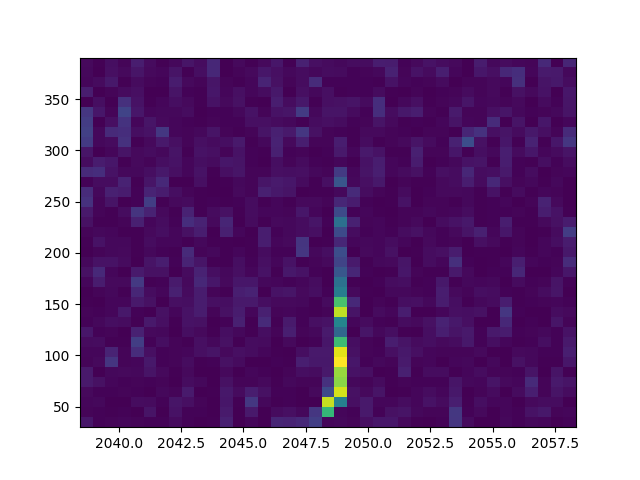

In [73]:
def spectrogram(x, y, windowtype, dxspec, ymin, ymax):
    """create a 2D spectrogram from time-series data
    define type of window to be used. dxspec defines f and x resolution"""
    dx = x[1] - x[0]
    neach = int(dxspec*2//dx)
    xstart = int(neach//2)
    xend = len(x) - xstart - 1
    jump = xstart
    nfft = int((xend - xstart)//jump)
    xspec = np.linspace(x[xstart], x[xend], num=nfft)
    yspec = np.fft.rfftfreq(neach, dx)
    z = np.zeros((nfft, len(yspec)), dtype='complex')
    window = windowtype(np.arange(neach), neach)
    for i in range(0, nfft):
        asd = np.fft.rfft(y[i*jump:i*jump+neach]*window)
        z[i, :] = asd*np.conj(asd)
    i1 = np.argmax(yspec > ymin)
    i2 = np.argmax(yspec > ymax)
    return xspec, yspec[i1:i2], np.real(z[:, i1:i2])


f1, f2 = 30, 400
t, f, spec = spectrogram(ts, strain, Hann, 0.05, f1, f2)
plt.figure()
plt.imshow(np.transpose(spec[int(9/0.05):-int(9/0.05), :]), cmap='viridis', origin='lower', aspect='auto', extent=[t[0],t[-1],f[0],f[-1]])

Perform a Q transform of the data.

<IPython.core.display.Javascript object>


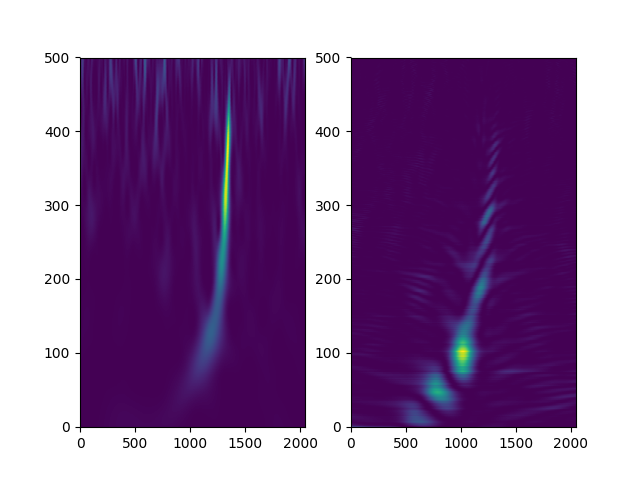

In [93]:
def slow_qtransform(x, y, qval, window, yeval):
    q = np.zeros((len(x), len(yeval)), dtype='complex')
    dx = x[1] - x[0]
    for i in range(0, len(yeval)):
        fi = yeval[i]
        windowxp = qval/fi
        windown = int(windowxp/dx)
        windowy = window(np.arange(windown), windown)
        windowy *= 1/np.sum(windowy)
        windowx = np.arange(windown)*dx
        windowyf = windowy * (np.cos(2*np.pi*fi*windowx) - 1j*np.sin(2*np.pi*fi*windowx))
        qpre = np.correlate(y, windowyf, mode='full')
        cut = int(np.floor(windown/2))
        q[:, i] = qpre[cut-1+windown%2:-cut]*np.conj(qpre[cut-1+windown%2:-cut])
    return np.real(q)


def fast_qtransform(x, y, qval, window, yeval):
    q = np.zeros((len(x), len(yeval)), dtype='complex')
    dx = x[1] - x[0]
    num = len(x)
    freqs = np.fft.rfftfreq(num, dx)
    yft = np.fft.rfft(y)
    for i in range(0, len(yeval)):
        fi = yeval[i]
        shift = int(fi/(freqs[1]-freqs[0]))
        yfti = np.zeros((len(yft)), dtype='complex')
        yfti[0:-shift] += yft[shift:]
        windown = int(qval/(fi*dx))
        windowy = np.zeros((num), dtype='float')
        windowy[:windown] += window(np.arange(windown), windown)
        windowft = np.fft.rfft(windowy)
        qft = yfti*np.conj(windowft)
        q0 = np.fft.irfft(qft)
        q[:, i] = q0*np.conj(q0)
    return np.real(q)

f1, f2 = 30, 400
feval = np.geomspace(f1, f2, endpoint=True, num=500)
#feval = np.linspace(f1, f2, endpoint=True, num=100)
qslow = slow_qtransform(ts, strain, 5, Hann, feval)
qfast = qtransform(ts, strain, 5, Hann, feval)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(qslow[int(9.7*fs):-int(9.8*fs), :]), cmap='viridis', origin='lower', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(qfast[int(9.7*fs):-int(9.8*fs), :]), cmap='viridis', origin='lower', aspect='auto')